In [111]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc as calculate_auc
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
from tqdm import tqdm

from aggmap import AggMap, AggMapNet
from aggmap import show, loadmap

from matplotlib.ticker import FormatStrFormatter
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import pandas as pd
import numpy as np
import os
sns.set(style='white',  font='sans-serif', font_scale=2)


from aggmap import loadmap, AggMapNet
from aggmap.AggMapNet import load_model

np.random.seed(888) #just for reaptable results

In [112]:
## AggMapNet parameters
epochs = 30 #number of epochs
lr = 1e-4 #learning rate
batch_size = 2 #batch size
conv1_kernel_size = 5 #kernal size of the first cnn layer
gpuid = 1 #use which gpu to train the model




def train(train_country,  megma = None):
    
    ## data process parameters
    minv = 1e-8 #minimal value for log-transform
    scale_method = 'standard' #data scaling method
    url = 'https://raw.githubusercontent.com/shenwanxiang/bidd-aggmap/master/docs/source/_example_MEGMA/dataset/'
    
    dfx_vector = pd.read_csv(url + '%s_dfx.csv' % train_country, index_col='Sample_ID')
    dfx_vector = np.log(dfx_vector + minv)
    dfy = pd.read_csv(url + '%s_dfy.csv' % train_country, index_col='Sample_ID')

    megma = AggMap(dfx_vector,  by_scipy=True)
    megma = megma.fit(var_thr = 3, random_state = 24, verbose=0,) # 16 17 18, 19 20

    X = megma.batch_transform(dfx_vector.values, scale_method = scale_method)
    Y = pd.get_dummies(dfy.Group).values
    
    # fit AggMapNet
    clf = AggMapNet.MultiClassEstimator(epochs = epochs,  
                                        batch_size = batch_size, 
                                        lr = lr, 
                                        conv1_kernel_size = conv1_kernel_size,
                                        gpuid = gpuid,
                                        verbose = 0)
    clf.fit(X, Y)
    return clf, megma

2022-08-17 19:53:10,219 - INFO - [bidd-aggmap] - Calculating distance ...


100%|###############################################################################| 849/849 [00:00<00:00, 5837.60it/s]

2022-08-17 19:53:10,392 - INFO - [bidd-aggmap] - applying hierarchical clustering to obtain group information ...


2022-08-17 19:53:10,912 - INFO - [bidd-aggmap] - Applying grid assignment of feature points, this may take several minutes(1~30 min)
2022-08-17 19:53:11,178 - INFO - [bidd-aggmap] - Finished


100%|###############################################################################| 109/109 [00:00<00:00, 2455.06it/s]

MultiClassEstimator(batch_norm=False, batch_size=2, conv1_kernel_size=5,
                    dense_avf='relu', dense_layers=[128], dropout=0.0,
                    epochs=30, gpuid='1', last_avf='softmax',
                    loss='categorical_crossentropy', lr=0.0001, metric='ACC',
                    monitor='val_loss', n_inception=2,
                    name='AggMap MultiClass Estimator', patience=10000,
                    random_state=32, verbose=0)


2022-08-17 19:53:32,993 - INFO - [bidd-aggmap] - calculating feature importance for class 0 ...


100%|#################################################################################| 756/756 [00:14<00:00, 53.84it/s]

2022-08-17 19:53:47,039 - INFO - [bidd-aggmap] - calculating feature importance for class 1 ...



100%|#################################################################################| 756/756 [00:14<00:00, 53.48it/s]

2.6


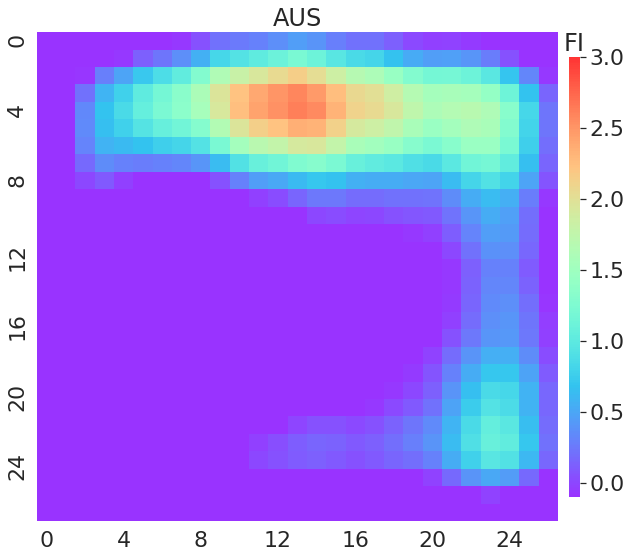

In [113]:
country = 'AUS'
clf, megma = train(country)

sxp = AggMapNet.simply_explainer(clf, megma, 
                                 backgroud = 'global_min', 
                                 apply_smoothing = True)
gfi = sxp.global_explain(clf.X_, clf.y_)
gfi.append(gfi.simply_importance_class_0.to_frame(name = country))


fig, ax  = plt.subplots(1, 1, figsize=(10, 9))

IMPM = gfi.simply_importance_class_0.values.reshape(*megma.fmap_shape)
print(IMPM.max().round(1))

sns.heatmap(IMPM,  
            cmap = 'rainbow', alpha = 0.8, xticklabels=4, ax =ax,
            yticklabels=4, vmin = -0.1, vmax = 3,
            cbar_kws = {'fraction':0.046, 'shrink':0.9, 'aspect': 40, 'pad':0.02, })

ax.set_title(country)
cbar = ax.collections[0].colorbar
cbar.ax.set_title('FI')
cbar.ax.yaxis.set_major_formatter(FormatStrFormatter("%.1f"))

plt.subplots_adjust(wspace = 0.18)

In [118]:
s = gfi.simply_importance_class_0.sort_values(ascending=False).head(50)

In [119]:
s

unknown Clostridiales [meta_mOTU_v2_7682]                        2.624457
unknown Clostridiales [meta_mOTU_v2_6134]                        2.581997
Bacteroides pectinophilus [ref_mOTU_v2_4341]                     2.553041
unknown Clostridiales [meta_mOTU_v2_5661]                        2.515998
unknown Clostridium [meta_mOTU_v2_5505]                          2.492302
unknown Clostridium [meta_mOTU_v2_6156]                          2.469115
unknown Clostridium [meta_mOTU_v2_6877]                          2.421269
unknown Clostridiales [meta_mOTU_v2_6128]                        2.383108
Clostridiales bacterium 41_21_two_genomes [meta_mOTU_v2_5482]    2.352333
unknown Roseburia [meta_mOTU_v2_5883]                            2.330281
Roseburia sp. CAG:303 [meta_mOTU_v2_6722]                        2.327295
unknown Clostridiales [meta_mOTU_v2_7620]                        2.257555
unknown Firmicutes [meta_mOTU_v2_7454]                           2.239537
Clostridium sp. CAG:594 [meta_mOTU_v2_

In [116]:
megma.fmap_shape

(28, 27)

In [117]:
megma.plot_scatter()

2022-08-17 19:54:01,309 - INFO - [bidd-aggmap] - generate file: ./feature points_733_correlation_umap_scatter
2022-08-17 19:54:01,316 - INFO - [bidd-aggmap] - save html file to ./feature points_733_correlation_umap_scatter
